In [1]:
import numpy as np
import pandas as pd
import math
from datetime import datetime
import pandas_datareader as pdr
import matplotlib.pyplot as plt

In [2]:
df = pdr.DataReader("USD/INR", "av-forex-daily", start=datetime(2014, 11, 7),end=datetime(2021, 2, 1),api_key='ALPHAVANTAGE_API_KEY')

In [3]:
df.tail(5)

,open,high,low,close
2021-01-26,72.970,73.070,72.833,72.910
2021-01-27,72.910,73.082,72.780,73.060
2021-01-28,73.060,73.180,72.876,72.930
2021-01-29,72.931,73.030,72.799,72.906
2021-02-01,72.906,73.190,72.805,73.110


In [4]:
df.index = pd.to_datetime(df.index)

<AxesSubplot:>

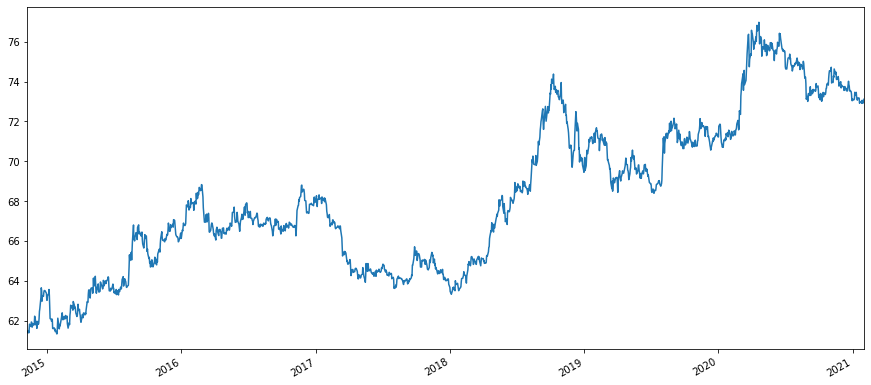

In [5]:
df1 = df["close"]

#plotting dataset to visualize the pattern of prices over the years

df1.plot(kind='line',figsize=(15,7))

In [6]:
df1.describe()

count    1626.000000
mean       68.150976
std         3.851962
min        61.343000
25%        64.869000
50%        67.397500
75%        71.196500
max        76.970000
Name: close, dtype: float64

In [7]:
df1.head()

2014-11-07    61.400
2014-11-10    61.495
2014-11-11    61.508
2014-11-12    61.391
2014-11-13    61.565
Name: close, dtype: float64

In [8]:
print(len(df1))

1626


2019-03-20    68.500
2019-03-21    68.750
2019-03-22    69.160
2019-03-25    68.920
2019-03-26    68.985
               ...  
2021-01-26    72.910
2021-01-27    73.060
2021-01-28    72.930
2021-01-29    72.906
2021-02-01    73.110
Name: close, Length: 489, dtype: float64


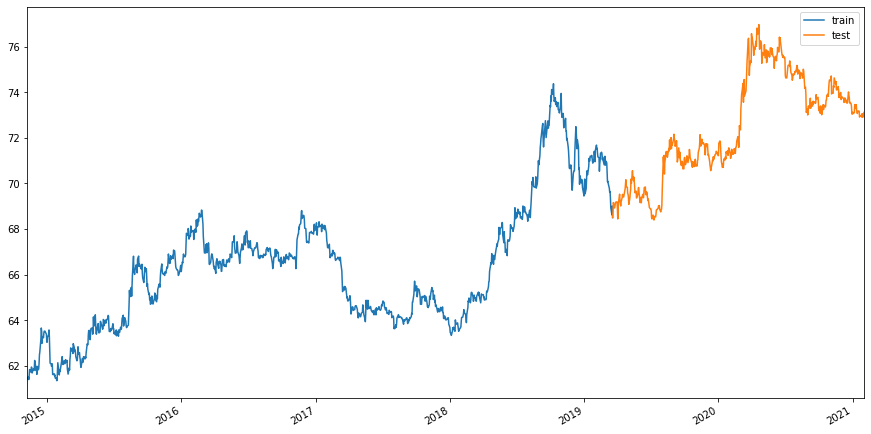

In [9]:
date_splt = pd.Timestamp('2019-03-20')
train = df1.loc[:date_splt]
test = df1.loc[date_splt:]
print(test)


ax = train.plot(kind='line',figsize=(15,8))
ax = test.plot(kind='line',figsize=(15,8))
plt.legend(['train', 'test'])

In [10]:
train = np.array(train).reshape(-1,1)
test = np.array(test).reshape(-1,1)

In [11]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()

In [12]:
train_std = stdsc.fit_transform(train.reshape(-1, 1))
test_std = stdsc.transform(test.reshape(-1,1))

In [13]:
X_train = train_std[:-1]
y_train = train_std[1:]

X_test = test_std[:-1]
y_test = test_std[1:]

In [14]:
print(y_train.shape)
print(X_train.shape)

(1137, 1)
(1137, 1)


In [15]:
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
import keras.backend as K
import tensorflow as tf 
import sklearn.metrics as metrics

Using TensorFlow backend.


In [16]:
X_train_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
y_train_t = y_train.reshape(-1,1) 

In [17]:
model = Sequential()
model.add(GRU(7, input_shape=(1, X_train.shape[1]), activation='linear', kernel_initializer='lecun_uniform', return_sequences=False))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 7)                 210       
_________________________________________________________________
dense (Dense)                (None, 1)                 8         
Total params: 218
Trainable params: 218
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(loss= tf.keras.metrics.mean_squared_error,
             metrics = [tf.keras.metrics.RootMeanSquaredError(name='rmse')],
             optimizer= 'adam')
history = model.fit(X_train_t, y_train_t, epochs=10, batch_size=1)

Epoch 1/10
1137/1137 [==============================] - 1s 694us/step - loss: 0.3901 - rmse: 0.6245
Epoch 2/10
1137/1137 [==============================] - 1s 863us/step - loss: 0.0629 - rmse: 0.2508
Epoch 3/10
1137/1137 [==============================] - 1s 921us/step - loss: 0.0128 - rmse: 0.1130
Epoch 4/10
1137/1137 [==============================] - 1s 798us/step - loss: 0.0089 - rmse: 0.0943
Epoch 5/10
1137/1137 [==============================] - 1s 831us/step - loss: 0.0084 - rmse: 0.0914
Epoch 6/10
1137/1137 [==============================] - 1s 1ms/step - loss: 0.0080 - rmse: 0.0894
Epoch 7/10
1137/1137 [==============================] - 1s 999us/step - loss: 0.0078 - rmse: 0.0882
Epoch 8/10
1137/1137 [==============================] - 1s 697us/step - loss: 0.0078 - rmse: 0.0885
Epoch 9/10
1137/1137 [==============================] - 1s 850us/step - loss: 0.0078 - rmse: 0.0884
Epoch 10/10
1137/1137 [==============================] - 1s 812us/step - loss: 0.0078 - rmse: 0.0885


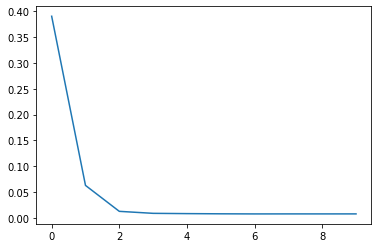

In [19]:
plt.plot(np.arange(0,10), history.history['loss'], label="loss")

In [20]:
def adjusted_r2(R2, n, p):
    ar2 = 1-(1-R2)*(n-1)/(n-p-1)
    return ar2

In [21]:
## Train_data

y_pred = model.predict(X_test_t)
y_train_pred = model.predict(X_train_t)

train_mse = metrics.mean_squared_error(y_train,y_train_pred)
root_mean_squared_error = np.sqrt(train_mse)

r2_train = r2_score(y_train, y_train_pred)
mean_absolute_error_train = metrics.mean_absolute_error(y_train, y_train_pred)
Adjusted_r2_score = adjusted_r2(r2_train, X_train.shape[0], X_train.shape[1])

print(Adjusted_r2_score)

0.9924720807754588


In [22]:
## Test_data

test_mse = metrics.mean_squared_error(y_test,y_pred)
root_mse_test = np.sqrt(test_mse)

r2_test = r2_score(y_test, y_pred)
mean_absolute_error_test = metrics.mean_absolute_error(y_test, y_pred)
Adjusted_r2_score_test = adjusted_r2(r2_test, X_test.shape[0], X_test.shape[1])

print(mean_absolute_error_test)

0.08283535123040167


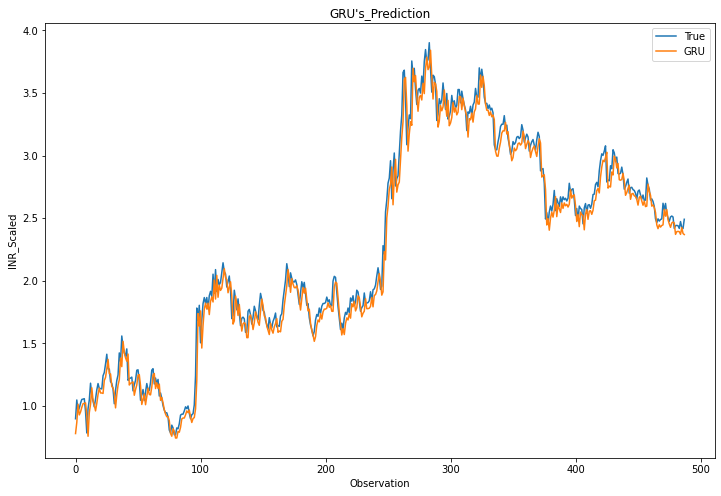

In [23]:
plt.figure(figsize=(12,8))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='GRU')
plt.title("GRU's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

In [24]:
inv_ytest = stdsc.inverse_transform(y_test)
inv_yhat = stdsc.inverse_transform(y_pred)

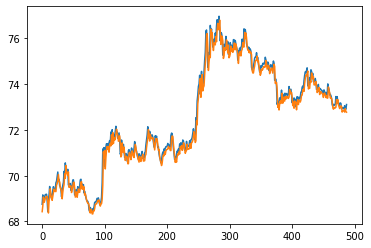

In [25]:
plt.plot(inv_ytest)
plt.plot(inv_yhat)

In [26]:
mse_test = metrics.mean_squared_error(inv_ytest, inv_yhat)
print(mse_test)

rmse = np.sqrt(mse_test)
print(rmse)

r2_test_inv = r2_score(inv_ytest, inv_yhat)
print(r2_test_inv) # r2 score

0.09019859888175795
0.3003308157378426
0.9823501382255319


In [27]:
df1.head()

2014-11-07    61.400
2014-11-10    61.495
2014-11-11    61.508
2014-11-12    61.391
2014-11-13    61.565
Name: close, dtype: float64

In [33]:
col1 = pd.DataFrame(inv_ytest , columns=['close'])
col2 = pd.DataFrame(inv_yhat, columns=['Predition'])
#col3 = pd.DataFrame(history.history['rmse'], columns=['RMSE'])

Final = pd.concat([col1,col2], axis=1)

In [38]:
Final.tail()

,close,Predition
483,72.910,72.839638
484,73.060,72.779869
485,72.930,72.929268
486,72.906,72.799797
487,73.110,72.775887


In [39]:
test_data = pd.DataFrame(df1.loc[date_splt:])
test_data.head()

,close
2019-03-20,68.500
2019-03-21,68.750
2019-03-22,69.160
2019-03-25,68.920
2019-03-26,68.985


In [40]:
test_data.reset_index(level=0, inplace=True)
test_data.head()

,index,close
0,2019-03-20,68.500
1,2019-03-21,68.750
2,2019-03-22,69.160
3,2019-03-25,68.920
4,2019-03-26,68.985


In [42]:
output = test_data.merge(Final,how='inner', left_on='close', right_on='close')
output.head()

,index,close,Predition
0,2019-03-21,68.75,68.426140
1,2019-03-21,68.75,68.785294
2,2019-07-29,68.75,68.426140
3,2019-07-29,68.75,68.785294
4,2019-03-22,69.16,68.668671


In [44]:
output.drop_duplicates(subset='index', inplace=True)
output.tail()

,index,close,Predition
581,2021-01-22,72.976,72.839638
582,2021-01-27,73.060,72.779869
583,2021-01-28,72.930,72.929268
584,2021-01-29,72.906,72.799797
585,2021-02-01,73.110,72.775887


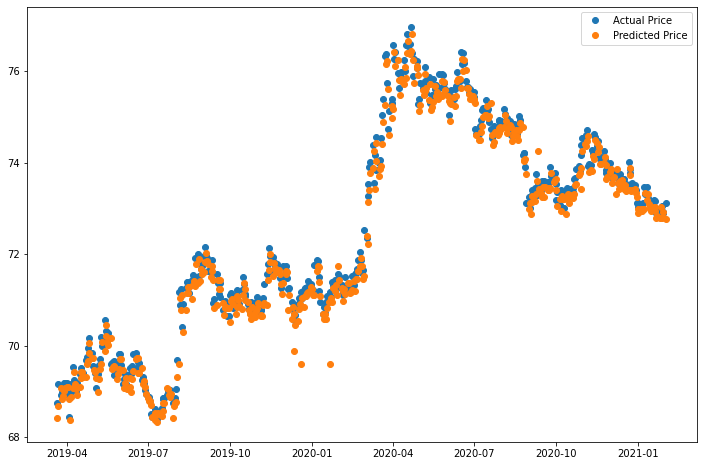

In [46]:
plt.figure(figsize=(12,8))
price_date = output['index']
price_true = output['close']
price_pred = output['Predition']
plt.plot_date(price_date, price_true,label='Actual Price')
plt.plot_date(price_date, price_pred,label='Predicted Price')
plt.legend()
plt.show()

In [48]:
output.describe()

,close,Predition
count,488.000000,488.000000
mean,72.484237,72.345215
std,2.262949,2.259874
min,68.399000,68.328316
25%,70.928500,70.776085
50%,72.094500,71.903294
75%,74.390000,74.252090
max,76.970000,76.804863
